# (Organic) Rankine Cycles

## Introduction

### ORC overview

Power production from thermal input

- steam generator (preheater, evaporator, superheater)
- turbine
- condenser
- feed pump

- In traditional clausius rankine cycle efficiency optimizations by means of
  more complex topology (regenerative preheater, superheating)
- Low grade temperature heat sources: simple cycles, power output maximization
- In all cases: Minimize LCOE/maximize ROI


### Contents

- Simple cycle using water as working fluid
- Analysing the cycle's performance
- Changing the heat source fluid
- Changing the working fluid and analyzing the performance
- Adapting components of the cycle for improved modeling
- Investigation of working fluids
- Plotting cycle diagrams with fluprodia
- Implementing a recuperated ORC
- Parametric analysis of the recuperated cycle

### Learnings

- Build multi-component cycle according to specifications
- Deal with starting value/numerical issues in tespy
- Use a library to plot cycle diagrams
- Conduct parametric analysis of influence factors

## Simple ORC cycle

In the simple cycle we will first model a rankine cycle using air as heat
source fluid, water as working fluid and air as heat sink fluid. The hot air
enters the plant at 160 °C. The ambient air enters the condenser at 20 °C. The
system is displayed below:

```{figure} /ORC_simple.svg
---
alt: Component based thermodynamic model of the simple ORC
name: simple-orc-flowsheet
---
Component based thermodynamic model of the simple ORC
```

Take all assumptions from the tables below.

### Connection parameters

| Name | Parameter | Value | Unit |
|:-----|:----------|------:|:-----|
| a1   | fluid     | air   | -    |
|      | T         | 160   | °C   |
|      | p         | 1     | bar  |
|      | m         | 100   | kg/s |
| c1   | fluid     | air   | -    |
|      | T         | 20    | °C   |
|      | p         | 1     | bar  |
| c2   | T         | 35    | °C   |
| b1   | fluid     | water | -    |
|      | T         | 140   | °C   |
|      | x         | 1     | -    |
| b3   | x         | 0     | -    |
| b5   | x         | 0     | -    |


### Component parameters

| Name                | Parameter | Value | Unit |
|---------------------|-----------|-------|------|
| Pump                | eta_s     | 75    | %    |
| Turbine             | eta_s     | 85    | %    |
| Evaporator          | ttd_l     | 5     | K    |
| Condenser           | ttd_l     | 15    | K    |
| All heat exchangers | dp1, dp2  | 0     | bar  |

### Tasks

1. Analyse the plant’s performance
   - Calculate the power generation
   - Calculate the thermal efficiency
   - Plot the cycle’s T-s diagram and include a plot of the saturation dome
2. Change the working fluid
   - Use isopentane instead of water
3. Analyse the plant's performance
   - Calculate the power generation
   - Calculate the thermal efficiency
   - Why do these change?
   - Plot the cycle’s T-s diagram
   - Consider the fact, that not only condensation takes place in the condenser
   - Plot the condenser’s Q-T diagram
4. Replace the condenser by with the MovingBoundaryHeatExchanger model
   - Impose a minimum pinch temperature difference of 5 K
5. Replace the heat source fluid from air to water
   - Assume the same temperature at the heat source inflow, consider a pressure
     of 10 bar

### Task 1

To set up the model, we first import the relevant dependencies from the tespy
package.

In [120]:
from tespy.networks import Network
from tespy.components import CycleCloser, Turbine, Pump, Source, Sink, HeatExchanger
from tespy.connections import Connection

Next we can create all components required from the flowsheet of the ORC.

In [121]:
nw = Network(T_unit="C", p_unit="bar")

heat_source_in = Source("heat source inlet")
heat_source_out = Sink("heat source outlet")

cc = CycleCloser("cycle closer")
preheater = HeatExchanger("preheater")
evaporator = HeatExchanger("evaporator")
turbine = Turbine("turbine")
condenser = HeatExchanger("condenser")
pump = Pump("feed pump")

cooling_in = Source("cooling inlet")
cooling_out = Sink("cooling outlet")

And connect the components in the way indicated.

In [122]:
a1 = Connection(heat_source_in, "out1", evaporator, "in1", label="a1")
a2 = Connection(evaporator, "out1", preheater, "in1", label="a2")
a3 = Connection(preheater, "out1", heat_source_out, "in1", label="a3")

b1 = Connection(cc, "out1", turbine, "in1", label="b1")
b2 = Connection(turbine, "out1", condenser, "in1", label="b2")
b3 = Connection(condenser, "out1", pump, "in1", label="b3")
b4 = Connection(pump, "out1", preheater, "in2", label="b4")
b5 = Connection(preheater, "out2", evaporator, "in2", label="b5")
b0 = Connection(evaporator, "out2", cc, "in1", label="b0")

c1 = Connection(cooling_in, "out1", condenser, "in2", label="c1")
c2 = Connection(condenser, "out2", cooling_out, "in1", label="c2")

nw.add_conns(a1, a2, a3)
nw.add_conns(b1, b2, b3, b4, b5, b0)
nw.add_conns(c1, c2)

Finally, we specify all the boundary conditions to the model.

```{note}
In this first task, we have set up the problem in a way, that it is solvable
withouth numerical issues. This will not be the case for the next steps. There
we will have to provide starting value guesses or use an approach with two
consecutive solves.
```

In [123]:
a1.set_attr(fluid={"air": 1}, p=1, T=160, m=100)
b1.set_attr(fluid={"water": 1}, x=1, T=140)
b3.set_attr(x=0)
b5.set_attr(x=0)

c1.set_attr(fluid={"air": 1}, p=1, T=20)
c2.set_attr(T=35)

preheater.set_attr(pr1=1, pr2=1)
evaporator.set_attr(pr1=1, pr2=1, ttd_l=5)
condenser.set_attr(pr2=1, pr1=1, ttd_l=17.5)
turbine.set_attr(eta_s=0.85)
pump.set_attr(eta_s=0.75)

Finally, we can run the model and have a look at the results.

In [124]:
nw.solve("design")
nw.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.38e+07   | 0 %        | 4.11e+04   | 1.86e+07   | 2.10e+06   | 0.00e+00   | 0.00e+00   
 2     | 3.87e+08   | 0 %        | 5.42e+04   | 7.59e+06   | 1.50e+06   | 0.00e+00   | 0.00e+00   
 3     | 1.88e+08   | 0 %        | 1.33e+04   | 3.50e+06   | 3.05e+05   | 0.00e+00   | 0.00e+00   
 4     | 2.68e+06   | 0 %        | 1.07e+02   | 1.50e+06   | 1.45e+05   | 0.00e+00   | 0.00e+00   
 5     | 1.07e+06   | 0 %        | 2.27e+01   | 6.06e+05   | 1.48e+05   | 0.00e+00   | 0.00e+00   
 6     | 7.81e+05   | 1 %        | 8.81e+00   | 2.19e+05   | 1.56e+05   | 0.00e+00   | 0.00e+00   
 7     | 5.33e+05   | 3 %        | 7.57e+00   | 7.17e+04   | 1.61e+05   | 0.00e+00   | 0.00e+00   
 8     | 2.92e+05   | 5 %        | 7.69e+00   | 2.15e+04   | 1.63e+05   | 0.00e+00   | 0.00e+00   
 9     | 

First, we want to calculat the total power output of the plant. This is the
turbine power minus the pump power. Since the turbine power is negative by
definition, you have to take this into account in the calculation.

$$\dot W_\text{total} = |\dot W_\text{turbine}|-\dot W_\text{pump}$$

In [125]:
power_output = abs(turbine.P.val) - pump.P.val
power_output

357323.50692817837

The thermal efficiency is defined as the power output of the plant divided by
the thermal input. The thermal input is the total amount of heat transferred to
the working fluid from the heat source side. The the two-sided heat exchanger
component of tespy always assigns a negative value for the heat transfer (it
is defined from the hot stream perspective, i.e. providing heat), we have to
use the absolute value of the sum.

$$\dot Q_\text{in} = |\dot Q_\text{preheater} + \dot Q_\text{evaporator}|$$



With that, the thermal efficiency is defined as follows:

$$\eta_\text{th} = \frac{\dot W_\text{total}}{\dot Q_\text{in}}$$

In [126]:
heat_input = abs(preheater.Q.val + evaporator.Q.val)
heat_input

1833408.597147453

In [127]:
thermal_efficiency = power_output / heat_input
thermal_efficiency

0.19489572999937252

For the T-s diagram of the cycle, we can use CoolProp to plot the saturation
dome and pass the results from our model to the same plot to display the state
points and processes. The state points can be passed as a list and we can
access the temperature and entropy value of all state points. To draw a
complete cycle, we include both b1 and b0, although they are the same point
(because they are connected by the cycle closer).

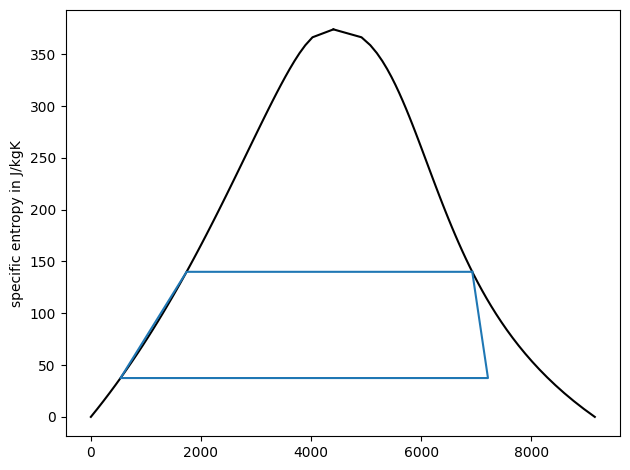

In [128]:
from matplotlib import pyplot as plt
from CoolProp.CoolProp import PropsSI as PSI
import numpy as np


working_fluid = "water"


fig, ax = plt.subplots(1)


dome_T = np.linspace(273.15, PSI("Tcrit", working_fluid))
dome_Q_0_s = PSI("S", "T", dome_T, "Q", 0, working_fluid)
dome_Q_1_s = PSI("S", "T", dome_T, "Q", 1, working_fluid)

ax.plot(dome_Q_0_s, dome_T - 273.15, color="black")
ax.plot(dome_Q_1_s, dome_T - 273.15, color="black")

# iterate through the relevant points in the cycle and extract T and s
process_T = [c.T.val for c in [b1, b2, b3, b4, b5, b0]]
process_s = [c.s.val for c in [b1, b2, b3, b4, b5, b0]]
ax.plot(process_s, process_T)

ax.set_ylabel("temperature in °C")
ax.set_ylabel("specific entropy in J/kgK")

plt.tight_layout()
plt.show()


We can see, that the turbine expansion starts at the saturated vapor line and
ends in the two-phase region. This is technically challenging, and usually
avoided in rankine power cycles as the increasing wettness of the steam will
damage the steam turbine blades. To solve this issue, the steam is often
superheated after evaporation. However, this is not feasible/optimal for low
temperature heat source applications. Instead, the working fluid is exchanged
by using an organic working fluid instead of water.

### Task 2

In this step we will exchange the working fluid based on the implications we
have identified in the in the previous tasks to use Isopentane instead of water.
To do this (in the jupyter notebook) we have to unset the fluid specification 
inside the main cycle and then specify an update fluid vector insead.

While the set of specifications is the same as previously, with the change of
the working fluid it may be possible to run into errors, as the starting values
for the simulation will be taken from the simulation performed with water as
working fluid. If pressure and enthalpy values change fundamentally, there is a
high chance of non-convergence. In this case it will work right out of the box.

```{note}
If you were to set up a network from scratch using Isopentane in the identical
configuration as in this part, then you will run into an error here. The
reason for that is, that the starting values for pressure are higher than the
critical pressure in some parts of the network, which makes it impossible to
calculate the residual value of the equations imposed by specification of `x`.

What we can to to fix this, is to set starting value guesses in the relevant
locations. The only points in our system, where we are trying to access 
two-phase properties are the connections `b3` and `b5`. We can manually specify
the starting value for pressure in those locations by calculating the
saturation pressure at the rough estimate for the temperature of these states
with CoolProp and then impose those on the cycle.

p_low = PSI("P", "T", 35 + 273.15, "Q", 0, "Isopentane") / 1e5
p_high = PSI("P", "T", 140 + 273.15, "Q", 0, "Isopentane") / 1e5

b3.set_attr(p0=p_low)
b5.set_attr(p0=p_high)

The issue does not stem from the b1 specification of vapor mass fraction. Here
the temperature has been specified along with the vapor mass fraction, which
will automatically presolve p and h for that connection and disable the
imposing of the equations for x and T at that connection.
```

In [129]:
b1.set_attr(fluid={"water": None})
b1.set_attr(fluid={"Isopentane": 1})

nw.solve("design")
nw.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 3.21e+06   | 0 %        | 2.83e+02   | 2.10e+06   | 2.86e+06   | 0.00e+00   | 0.00e+00   
 2     | 6.75e+06   | 0 %        | 6.03e+01   | 7.87e+04   | 1.80e+05   | 0.00e+00   | 0.00e+00   
 3     | 2.78e+06   | 0 %        | 2.49e+02   | 6.00e+04   | 4.12e+04   | 0.00e+00   | 0.00e+00   
 4     | 5.55e+04   | 13 %       | 3.00e+00   | 1.19e+04   | 1.46e+03   | 0.00e+00   | 0.00e+00   
 5     | 1.18e+02   | 43 %       | 1.09e-02   | 2.98e+02   | 3.09e+01   | 0.00e+00   | 0.00e+00   
 6     | 6.84e-02   | 79 %       | 5.93e-06   | 1.71e-01   | 1.66e-02   | 0.00e+00   | 0.00e+00   
 7     | 4.53e-07   | 100 %      | 2.74e-07   | 2.88e-03   | 1.57e-03   | 0.00e+00   | 0.00e+00   
 8     | 5.57e-09   | 100 %      | 2.37e-12   | 2.40e-08   | 1.38e-08   | 0.00e+00   | 0.00e+00   
Total ite

Now we can have a look at a couple of results again. First, the total power
output. Its value is significantly higher compared to the cycling employing
water as working fluid. But if we look at the thermal efficiency it has
decreased.

In [130]:
power_output = abs(turbine.P.val) - pump.P.val
power_output

526728.3301372845

In [131]:
heat_input = abs(preheater.Q.val + evaporator.Q.val)
thermal_efficiency = power_output / heat_input
thermal_efficiency

0.1527220692680467

If we look into the heat input we will see, that it is much higher than the
heat input using water as working fluid. This means, that more heat was
exploited from the air by cooling it down much more. The pinch point at the
evaporator fixes the air temperature at the evaporator outlet. Since in both
cases the evaporation temperature has been chosen to be identical, Isopentane
must allow to extract more heat in the preheating phase. You can see this by
comparing the T-s diagrams (Q-T actually) of both fluids. For Isopentane the 
heat input is distributed similarly for both preheating and evaporating. For
water most of the heat is consumed for evaporating leaving little amount of
heat exchage in the preheating part, thus cooling the air less down in that
part.

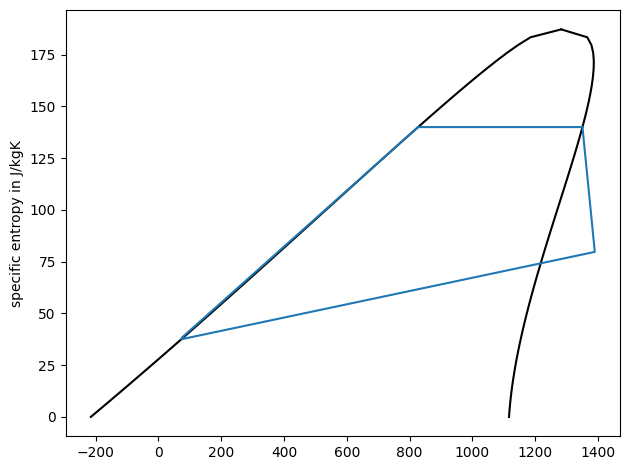

In [132]:
from matplotlib import pyplot as plt
from CoolProp.CoolProp import PropsSI as PSI
import numpy as np


working_fluid = "Isopentane"


fig, ax = plt.subplots(1)


dome_T = np.linspace(273.15, PSI("Tcrit", working_fluid))
dome_Q_0_s = PSI("S", "T", dome_T, "Q", 0, working_fluid)
dome_Q_1_s = PSI("S", "T", dome_T, "Q", 1, working_fluid)

ax.plot(dome_Q_0_s, dome_T - 273.15, color="black")
ax.plot(dome_Q_1_s, dome_T - 273.15, color="black")

# iterate through the relevant points in the cycle and extract T and s
process_T = [c.T.val for c in [b1, b2, b3, b4, b5, b0]]
process_s = [c.s.val for c in [b1, b2, b3, b4, b5, b0]]
ax.plot(process_s, process_T)

ax.set_ylabel("temperature in °C")
ax.set_ylabel("specific entropy in J/kgK")

plt.tight_layout()
plt.show()

Now in the T-s diagram the condensation process does not look right. We have
just connected the outlet of the turbine in a straight line with the outlet
of the condenser. However, it should follow a isobaric line, which would be
at constant temperature in the two-phase region. To do this, we have to 
calculate one intermediate state, namely, the saturation point at saturated
vapor.

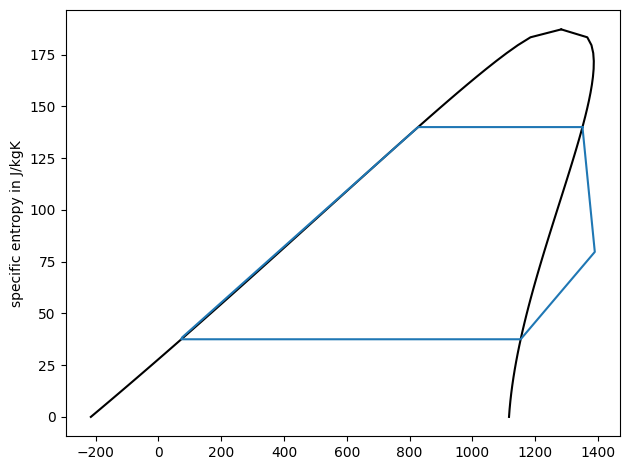

In [133]:
fig, ax = plt.subplots(1)

ax.plot(dome_Q_0_s, dome_T - 273.15, color="black")
ax.plot(dome_Q_1_s, dome_T - 273.15, color="black")

# calculate the saturated vapor state
T_sat = PSI("T", "P", b2.p.val_SI, "Q", 1, working_fluid) - 273.15
s_sat = PSI("S", "P", b2.p.val_SI, "Q", 1, working_fluid)

process_T = [c.T.val for c in [b1, b2, b3, b4, b5, b0]]
process_s = [c.s.val for c in [b1, b2, b3, b4, b5, b0]]
# insert the saturation state
process_T.insert(2, T_sat)
process_s.insert(2, s_sat)

ax.plot(process_s, process_T)

ax.set_ylabel("temperature in °C")
ax.set_ylabel("specific entropy in J/kgK")

plt.tight_layout()
fig.savefig("Ts_cycle.svg")

For the Q-T diagram of the condenser, we want to plot how the temperature
changes over the amount of heat transferred. We can do this in a similar way,
i.e. by sectioning the heat exchanged into the desuperheating part and the
condensation part. For the Q-T diagram we need to calculate the enthalpy at the
phase change point and then use the enthalpy differences to calculate the
corresponding heat exchanged. For the cold side we can use that same sectioning
point in terms of heat exchanged and then calculate the temperature
by first determinig the enthalpy of the cold side fluid corresponding the the
amount of heat exchanged up until that point.

In [134]:
h_steps_hot = [b2.h.val_SI, PSI("H", "P", b2.p.val_SI, "Q", 1, working_fluid), b3.h.val_SI]
T_steps_hot = [PSI("T", "P", b2.p.val_SI, "H", h, working_fluid) for h in h_steps_hot]
delta_h_steps = [0, h_steps_hot[0] - h_steps_hot[1], h_steps_hot[1] - h_steps_hot[2]]
Q_steps = [dh * b2.m.val_SI for dh in delta_h_steps]
Q_steps

[0.0, 552570.671462325, 2369634.9518345166]

For the cold side we can now assign the sections for enthalpy. Note that we
have to iterate in the reverse order, because we are dealing with a counter
current heat exchanger and the heat exchanged was calculated based on the
sections from hot side inlet to hot side outlet. These correspond to the 
sections from cold side outlet to cold side inlet.

In [135]:
h_steps_cold = [c2.h.val_SI - Q / c1.m.val_SI for Q in Q_steps]
h_steps_cold

[434503.8357063526, 431649.3216114342, 422262.58455213875]

Temperature can then be calculated in the same way as before.

In [136]:
T_steps_cold = [PSI("T", "P", c1.p.val_SI, "H", h, "air") for h in h_steps_cold]

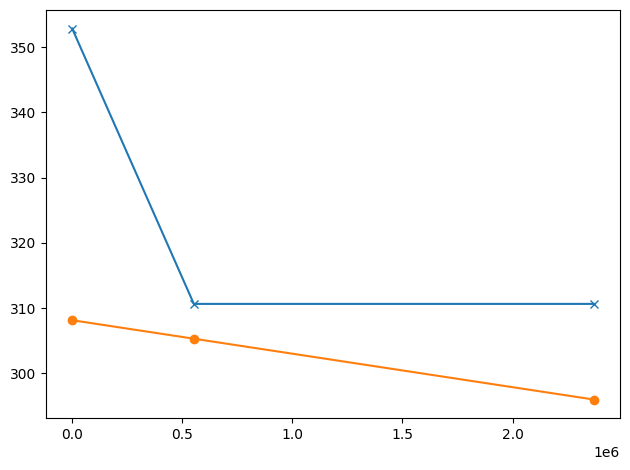

In [137]:
fig, ax = plt.subplots(1)

ax.plot(Q_steps, T_steps_hot, "x-")
ax.plot(Q_steps, T_steps_cold, "o-")

plt.tight_layout()

## Task 4

We can replace the heat exchanger in our model with an instance of the
MovingBoundaryHeatExchanger class. This type of heat exchanger has the
sectioning we just performed inbuilt, which will also allow us,

- to directly make a specification of the minimum temperature difference
  between the working fluid and the air, i.e. the pinch temperature difference.
  As we have seen, this might not necessarily be the lower or upper terminal
  temperature difference.
- to easily plot the Q-T diagram of the component, as it has inbuilt
  methods to retrieve the section temperatures and heat exchange.

To do this, we can take the previous model, remove the relevant connections
and insert the new instance. The advantage of this method is, that the starting
values for the remaining part of the network are then still present.

In [138]:
from tespy.components import MovingBoundaryHeatExchanger


nw.del_conns(b2, b3, c1, c2)

condenser = MovingBoundaryHeatExchanger("condenser")

b2 = Connection(turbine, "out1", condenser, "in1", label="b2")
b3 = Connection(condenser, "out1", pump, "in1", label="b3")

c1 = Connection(cooling_in, "out1", condenser, "in2", label="c1")
c2 = Connection(condenser, "out2", cooling_out, "in1", label="c2")

nw.add_conns(b2, b3, c1, c2)

Now we have to reimpose those connection boundary conditions, that were 
previously imposed (since the connections are now new objects).

In [139]:
condenser.set_attr(pr1=1, pr2=1, td_pinch=5)

b3.set_attr(x=0)

c1.set_attr(fluid={"air": 1}, p=1, T=20)
c2.set_attr(T=35)

In [140]:
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 6.54e+06   | 0 %        | 8.71e-02   | 5.21e+06   | 6.20e+05   | 0.00e+00   | 0.00e+00   
 2     | 2.95e+06   | 0 %        | 1.19e+00   | 4.40e+06   | 1.18e+05   | 0.00e+00   | 0.00e+00   
 3     | 2.01e+06   | 0 %        | 2.14e+02   | 4.03e+06   | 7.15e+05   | 0.00e+00   | 0.00e+00   
 4     | 5.65e+05   | 2 %        | 7.78e+00   | 1.70e+06   | 3.74e+04   | 0.00e+00   | 0.00e+00   
 5     | 2.48e+05   | 6 %        | 5.55e+00   | 6.52e+05   | 1.12e+04   | 0.00e+00   | 0.00e+00   
 6     | 8.27e+04   | 12 %       | 2.46e+00   | 1.84e+05   | 5.10e+03   | 0.00e+00   | 0.00e+00   
 7     | 1.09e+04   | 21 %       | 6.03e+00   | 5.64e+04   | 4.18e+04   | 0.00e+00   | 0.00e+00   
 8     | 3.82e+03   | 26 %       | 9.82e-01   | 7.59e+03   | 1.76e+03   | 0.00e+00   | 0.00e+00   
 9     | 

we can now retrieve the respective results directly from the heat exchanger
object. The method `calc_sections` returns 5 arrays, which are:

- The cumulative heat exchanged at the phase change steps beginning at the cold
  side inlet
- The hot side temperature steps in reversed order (from outlet to inlet)
- The cold side temperature steps from its inlet to its outlet
- The amount of heat exchanged in every of the sections
- The logarithmic temperature difference of every section

We will only use the frist three for the Q-T diagram.

In [141]:
Q_steps, T_steps_hot, T_steps_cold, _, _ = condenser.calc_sections()
Q_steps, T_steps_hot, T_steps_cold

(array([0.00000000e+00, 8.98905415e-10, 2.37156202e+06, 2.92529987e+06]),
 array([310.31126541, 310.31126541, 310.31126541, 352.64491737]),
 array([293.15      , 293.15      , 305.31126541, 308.15      ]))

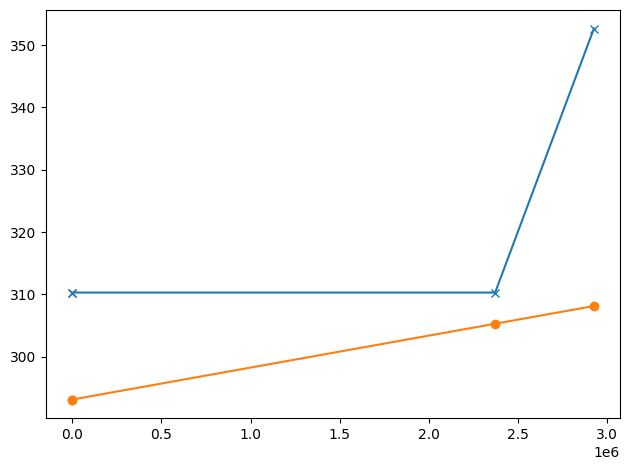

In [142]:
fig, ax = plt.subplots(1)

ax.plot(Q_steps, T_steps_hot, "x-")
ax.plot(Q_steps, T_steps_cold, "o-")

plt.tight_layout()
fig.savefig("QT_condenser.svg")

### Task 5

Now we will use water instead of air as heat source fluid. Typically this would
be the case in geothermal ORC applications. 

In [143]:
a1.set_attr(fluid={"air": None})
a1.set_attr(fluid={"water": 1}, p=10)
nw.solve("design")

Singularity in jacobian matrix, calculation aborted! Make sure your network does not have any linear dependencies in the parametrisation. Other reasons might be
-> given temperature with given pressure in two phase region, try setting enthalpy instead or provide accurate starting value for pressure.
-> given logarithmic temperature differences or kA-values for heat exchangers, 
-> support better starting values.
-> bad starting value for fuel mass flow of combustion chamber, provide small (near to zero, but not zero) starting value.



 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.15e+07   | 0 %        | NaN        | NaN        | NaN        | NaN        | NaN        
Total iterations: 1, Calculation time: 0.03 s, Iterations per second: 31.25


The specification results in a linear dependency of our problem. The good news
is, that we can be sure, that the set of specifications should not be the
reason for it, because we successfully ran the simulations using air as heat
source fluid already. What causes the issue here is therefore most likely the
starting values in the heat source side. The `a1` specification is complete 
with pressure and temperature, therefore the reason must lie within the 
starting values of `a2` and/or `a3`. We can provide starting values for
pressure and enthalpy. In this specific case, the only coupling of the heat
source side to the main cycles stems from the evaporator pinch. Therefore, it
is most likely that adjusting the respective starting values of connection `a2`
will fix the issue. Specifying an enthalpy starting value, where the water is
guaranteed in liquid phase for that connection is sufficient here:

In [144]:
a2.set_attr(h0=140e3)
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 6.60e+07   | 0 %        | 6.76e+02   | 1.27e+06   | 4.67e+05   | 0.00e+00   | 0.00e+00   
 2     | 8.74e-01   | 67 %       | 4.76e+01   | 2.86e-03   | 9.27e+03   | 0.00e+00   | 0.00e+00   
 3     | 2.11e-03   | 96 %       | 1.19e-02   | 3.39e-06   | 2.31e+00   | 0.00e+00   | 0.00e+00   
 4     | 6.19e-09   | 100 %      | 8.69e-10   | 2.47e-08   | 1.69e-07   | 0.00e+00   | 0.00e+00   
 5     | 7.58e-09   | 100 %      | 5.86e-11   | 9.92e-09   | 1.12e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.13 s, Iterations per second: 38.37


## ORC working fluids

Among others, the following working fluids are often applied in ORC plants:

- Isopentane
- n-Pentane
- Cyclopentane
- Isobutane
- n-Butane

### Tasks

1. Plot the saturation domes of the working fluids listed above and of water in
   a common T-s diagram.
   - What could be the reasons, why organic fluids are preferrable to water in
     low temperature heat applications?
2. Use fluprodia to create T-s diagram for Isopentane.
   - Create the base plot.
   - Add the state points and process lines of the last iteration of our system
     to the plot. Make use of fluprodia as well.

### Task 1

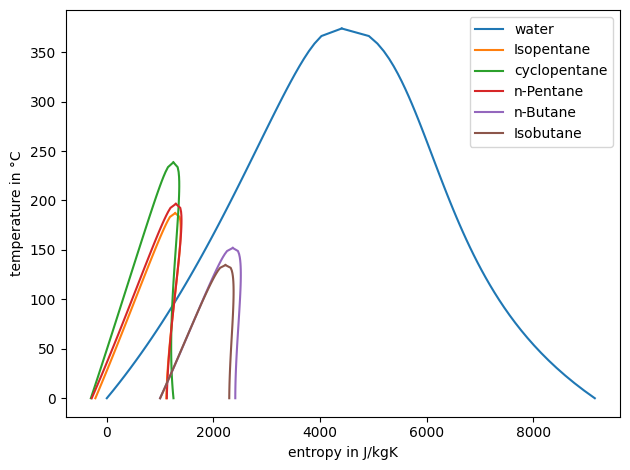

In [145]:
fluids = ["water", "Isopentane", "cyclopentane", "n-Pentane", "n-Butane", "Isobutane"]
fig, ax = plt.subplots(1)

for i, fluid in enumerate(fluids):

    dome_T = np.linspace(273.15, PSI("Tcrit", fluid))
    dome_Q_0_s = PSI("S", "T", dome_T, "Q", 0, fluid)
    dome_Q_1_s = PSI("S", "T", dome_T, "Q", 1, fluid)

    _ = ax.plot(dome_Q_0_s, dome_T - 273.15)
    ax.plot(dome_Q_1_s, dome_T - 273.15, color=_[0].get_color(), label=fluid)

ax.set_xlabel("entropy in J/kgK")
ax.set_ylabel("temperature in °C")
ax.legend()

plt.tight_layout()
fig.savefig("Ts_working_fluids.svg")

### Task 2

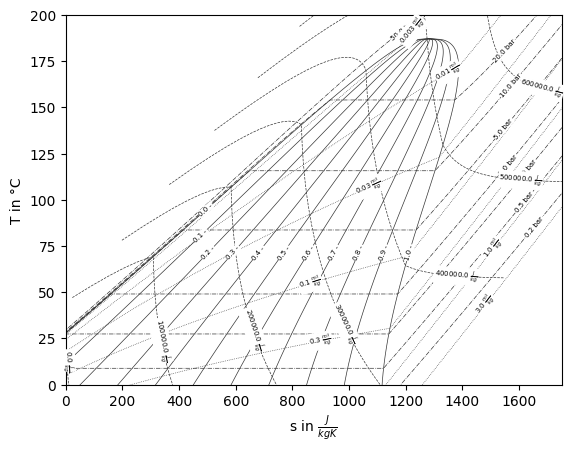

In [146]:
from fluprodia import FluidPropertyDiagram


diagram = FluidPropertyDiagram("Isopentane")

diagram.set_unit_system(T="°C", p="bar")
diagram.set_isolines_subcritical(0, 200)
diagram.calc_isolines()

fig, ax = plt.subplots(1)

diagram.draw_isolines(fig, ax, "Ts", 0, 1750, 0, 200)

plt.show()

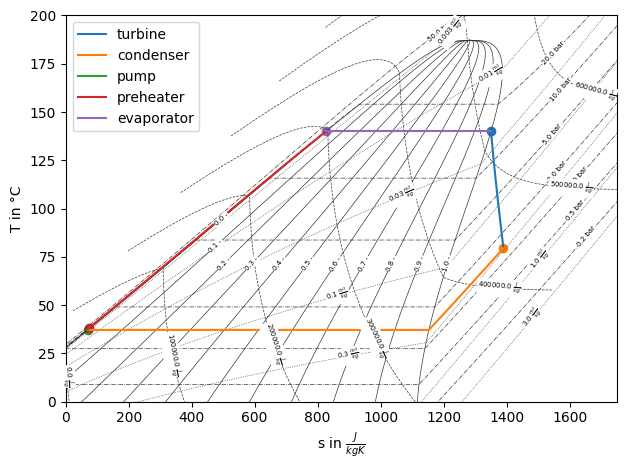

In [147]:
fig, ax = plt.subplots(1)

diagram.draw_isolines(fig, ax, "Ts", 0, 1750, 0, 200)

processes = {}
data = turbine.get_plotting_data()[1]
processes["turbine"] = diagram.calc_individual_isoline(**data)

data = condenser.get_plotting_data()[1]
processes["condenser"] = diagram.calc_individual_isoline(**data)

data = pump.get_plotting_data()[1]
processes["pump"] = diagram.calc_individual_isoline(**data)

data = preheater.get_plotting_data()[2]
processes["preheater"] = diagram.calc_individual_isoline(**data)

data = evaporator.get_plotting_data()[2]
processes["evaporator"] = diagram.calc_individual_isoline(**data)

for label, data in processes.items():
    ax.plot(data["s"], data["T"], label=label)
    ax.scatter(data["s"][0], data["T"][0])

ax.legend()
plt.tight_layout()
fig.savefig("Ts_fluprodia.svg")

In [148]:
power_non_recuperateod = abs(turbine.P.val) - pump.P.val

## Advanced ORC cycle

### Tasks

1. Add an internal heat recuperation to your model
   - Impose a hot side effectiveness of 0.5 to the recuperator
2. Analyse the results of the simulation
   - How do they compare to the previous model?
   - Which results change and which results remain unchanged?
3. Make a parametric analysis with the model
   - How does the performance of the cycle change for different sizes of the
     recuperator?
   - Change the size of recuperator by modifying the effectiveness.
   - How does the turbine inlet temperature affect the power output?
4. Change the imposed boundary conditions in a way, you can calculate the
   recuperator heat exchanged for a turbine inlet temperature of 100 °C and a 
   temperature of 80 °C of the heat source fluid leaving the preheater.
   

### Task 1

First, we can modify the topology. Since many connections have been relabeled
in the topology, we will just rebuild the model from scratch in this notebook.
The components can be reused, but a new network object will be set up.
Additionally, we add the recuperator.

In [149]:
nw = Network(T_unit="C", p_unit="bar")

recuperator = HeatExchanger("recuperator")

a1 = Connection(heat_source_in, "out1", evaporator, "in1", label="a1")
a2 = Connection(evaporator, "out1", preheater, "in1", label="a2")
a3 = Connection(preheater, "out1", heat_source_out, "in1", label="a3")

b1 = Connection(cc, "out1", turbine, "in1", label="b1")
b2 = Connection(turbine, "out1", recuperator, "in1", label="b2")
b3 = Connection(recuperator, "out1", condenser, "in1", label="b3")
b4 = Connection(condenser, "out1", pump, "in1", label="b4")
b5 = Connection(pump, "out1", recuperator, "in2", label="b5")
b6 = Connection(recuperator, "out2", preheater, "in2", label="b6")
b7 = Connection(preheater, "out2", evaporator, "in2", label="b7")
b0 = Connection(evaporator, "out2", cc, "in1", label="b0")

c1 = Connection(cooling_in, "out1", condenser, "in2", label="c1")
c2 = Connection(condenser, "out2", cooling_out, "in1", label="c2")

nw.add_conns(a1, a2, a3)
nw.add_conns(b1, b2, b3, b4, b5, b6, b7, b0)
nw.add_conns(c1, c2)

In [150]:
working_fluid = "Isopentane"

a1.set_attr(fluid={"water": 1}, p=10, T=160, m=100)

p_high = PSI("P", "T", 140 + 273.15, "Q", 1, working_fluid) / 1e5
p_low = PSI("P", "T", 50 + 273.15, "Q", 1, working_fluid) / 1e5

# starting value guess for water (see previous section)
a2.set_attr(h0=140000)

b1.set_attr(fluid={working_fluid: 1}, x=1, T=140)
# specification for starting values inside cycle as seen previously
b3.set_attr(p0=p_low)
b4.set_attr(x=0, p0=p_low)
b7.set_attr(x=0, p0=p_high)

c1.set_attr(fluid={"air": 1}, p=1, T=20)
c2.set_attr(T=35)

# component specific parameters do not need to be imposed again,
# since they are still associated with the objects

With all other specifications remaining unchanged, we can impose the hot side
effectiveness of the recuperator. On top of that, we also need to set the 
pressure drop on that heat exchanger to be equal to zero. The hot side
effectivenss $\text{eff}_\text{hot}$ is defined as the ratio of the actual change of
temperature on the hot side to the maximum possible change of temperature. The
maximum possible change is cooling the hot side from its inlet temperature down 
to the cold side inlet temperature leaving a lower terminal temperature
difference of 0 K. In this way it is an analogy to the isentropic efficiency of
turbomachines, which compares the actual change of enthalpy to the change of
enthalpy in the isentropic process.

It is also possible to express this relationship as function of enthalpy, then
the change of enthalpy is taken into consideration

$$
\text{eff}_\text{hot} =
\frac{h_\text{in,hot} - h_\text{out,hot}}{h_\text{in,hot} - h\left(T_\text{in,cold}, p_\text{out,hot}\right)}
$$

We can run the model...

In [151]:
recuperator.set_attr(pr1=1, pr2=1, eff_hot=0.5)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 8.90e+07   | 0 %        | 3.67e+01   | 4.53e+07   | 1.71e+07   | 0.00e+00   | 0.00e+00   
 2     | 3.80e+07   | 0 %        | 7.72e+02   | 3.98e+07   | 2.23e+06   | 0.00e+00   | 0.00e+00   


ValueError: unable to solve 1phase PY flash with Tmin=114.152, Tmax=750 due to error: HSU_P_flash_singlephase_Brent could not find a solution because Hmolar [-25958.6 J/mol] is below the minimum value of -24814.7043358 J/mol

... and see, that the model crashes unexpectedly. It is difficult to guess,
what the problem is here. So we will instead of specifying the hot side
effectiveness of the recuperator fix its hot side outlet state. This is easier
for the solver to handle. 

```{attention}
Before we can change the specifications and rerun the simulation, we have to
call a method to reset the network, in case an unexpected crash of the
simulation occured.
```

In [152]:
nw.reset_topology_reduction_specifications()

In [153]:
recuperator.set_attr(eff_hot=None)
b3.set_attr(Td_bp=5)
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 8.90e+07   | 0 %        | 5.36e+02   | 4.52e+08   | 1.84e+08   | 0.00e+00   | 0.00e+00   
 2     | 1.80e+07   | 0 %        | 5.11e+02   | 3.84e+06   | 1.41e+06   | 0.00e+00   | 0.00e+00   
 3     | 1.88e+07   | 0 %        | 3.66e+02   | 1.35e+06   | 4.91e+05   | 0.00e+00   | 0.00e+00   
 4     | 1.27e+06   | 0 %        | 1.75e+00   | 5.67e+05   | 5.50e+04   | 0.00e+00   | 0.00e+00   
 5     | 2.15e+05   | 7 %        | 1.43e+00   | 2.14e+05   | 1.17e+04   | 0.00e+00   | 0.00e+00   
 6     | 5.63e+04   | 13 %       | 1.17e-01   | 5.63e+04   | 5.80e+02   | 0.00e+00   | 0.00e+00   
 7     | 2.67e-01   | 73 %       | 8.05e-03   | 1.40e+00   | 7.37e-01   | 0.00e+00   | 0.00e+00   
 8     | 1.40e-03   | 98 %       | 9.24e-08   | 2.57e-06   | 1.77e-07   | 0.00e+00   | 0.00e+00   
 9     | 

Now with a good guess in place, we can retry to impose the hot side
effectiveness.

In [154]:
recuperator.set_attr(eff_hot=0.5)
b3.set_attr(Td_bp=None)
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 3.04e+04   | 16 %       | 6.31e+01   | 1.07e+04   | 4.52e+04   | 0.00e+00   | 0.00e+00   
 2     | 5.35e+01   | 47 %       | 2.47e-01   | 1.06e+03   | 4.85e+02   | 0.00e+00   | 0.00e+00   
 3     | 5.46e-01   | 69 %       | 1.49e-04   | 1.76e+00   | 9.85e-02   | 0.00e+00   | 0.00e+00   
 4     | 1.51e-06   | 100 %      | 2.26e-10   | 4.39e-06   | 3.29e-07   | 0.00e+00   | 0.00e+00   
 5     | 3.63e-08   | 100 %      | 7.23e-11   | 2.00e-09   | 1.72e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.11 s, Iterations per second: 45.12


### Task 2

The key parameter for our ORC is the power output. Along with that, we will
investigate the thermal efficiency.

In [155]:
power_output = abs(turbine.P.val) - pump.P.val
heat_input = abs(preheater.Q.val + evaporator.Q.val)
thermal_efficiency = power_output / heat_input
power_output, thermal_efficiency

(2204152.37840438, 0.16432096486749212)

In [156]:
power_non_recuperateod

2243106.8711812897

We can see, that the non-recuperated cycle produces more power than the
recuperated cycle, although it has a higher thermal efficiency value. It has a
similar effect as using water instead of the ORC working fluid: It reduces the
degree of exploitation of the heat resource. Why would one install this system,
if the power output is degraded? The answer is: When the heat source outflow
temperature is restricted with a lower limit. Reasons for this are, for
example:

- To avoid condensation in a humid waste heat air stream to prevent or
- To avoid precipitation of mineral substances in geo fluids, which form below
  a threshold temperature.

In both cases the equipment could degrade over time.

We can check the outflow temperature of the system to see if it is critical or
not. Lower temperature limits for geo fluids depend on the salinity of the 
fluid and typically are around 70 °C to 90 °C. With the current configuration
there is no issue in place:

In [157]:
a3.T.val

128.75107513011494

### Task 3

Recuperator size (-> effectiveness) study

In [158]:
recuperator.set_attr(eff_hot=0.5)

power = []
thermal_efficiency = []
T_outflow = []
nw.set_attr(iterinfo=False)
T_turbine_in_range = [150, 140, 130, 120, 110, 100, 90, 80]

for T in T_turbine_in_range:
    b1.set_attr(T=T)
    nw.solve("design")
    T_outflow.append(a3.T.val)
    power.append(abs(turbine.P.val) - pump.P.val)
    thermal_efficiency.append(power[-1] / abs(preheater.Q.val + evaporator.Q.val))


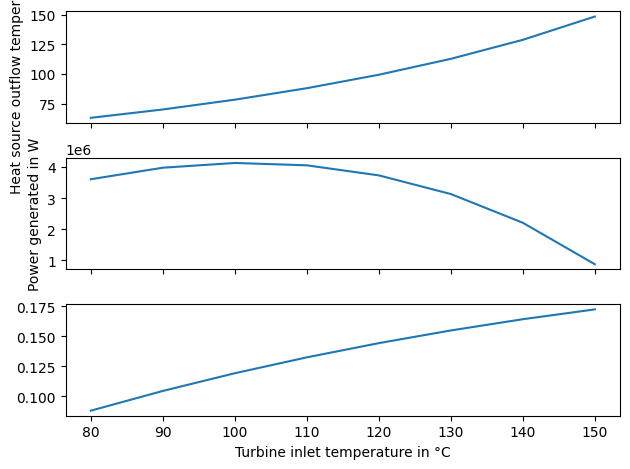

In [159]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(T_turbine_in_range, T_outflow)
ax[1].plot(T_turbine_in_range, power)
ax[2].plot(T_turbine_in_range, thermal_efficiency)

ax[0].set_ylabel("Heat source outflow temperature °C")
ax[1].set_ylabel("Power generated in W")
ax[2].set_xlabel("Thermal efficiency")
ax[2].set_xlabel("Turbine inlet temperature in °C")

plt.tight_layout()
plt.show()

In [160]:
eff_range = np.linspace(0.0, 0.95, 20)
power = []
thermal_efficiency = []
T_outflow = []
nw.set_attr(iterinfo=False)
b1.set_attr(T=100)

for eff in eff_range:
    recuperator.set_attr(eff_hot=eff)
    nw.solve("design")
    power += [abs(turbine.P.val) - pump.P.val]
    thermal_efficiency += [power[-1] / abs(preheater.Q.val + evaporator.Q.val)]
    T_outflow += [a3.T.val]

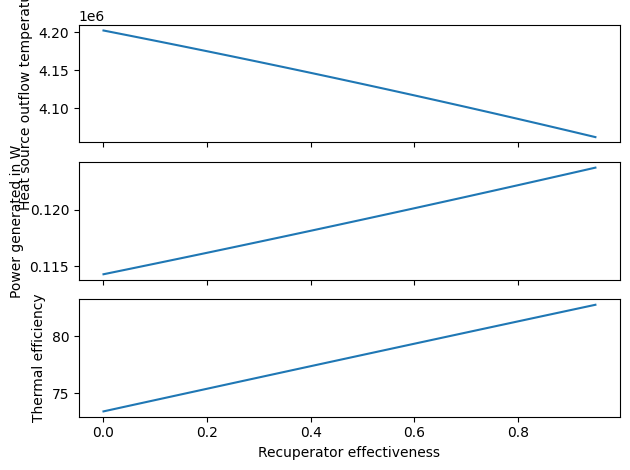

In [161]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(eff_range, power)
ax[1].plot(eff_range, thermal_efficiency)
ax[2].plot(eff_range, T_outflow)

ax[0].set_ylabel("Heat source outflow temperature °C")
ax[1].set_ylabel("Power generated in W")
ax[2].set_ylabel("Thermal efficiency")
ax[2].set_xlabel("Recuperator effectiveness")

plt.tight_layout()
plt.show()

In [ ]:
recuperator.set_attr(eff_hot=None)
a3.set_attr(T=80)
nw.solve("design")

recuperator.eff_hot.val

0.6657112886048473